Esse _notebook_ tem a função de ser utilizado para realizar testes em modelos específicos carregados à partir de checkpoints salvos.
Como o limite para arquivos no _github_ é de 100MB, a maioria dos checkpoints criados no trabalho não pode ser colocada no repositório.

In [1]:
import torchseg
from torch import nn
import torch
import train
import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from dataset import get_dataset
    
ds_train, ds_valid, class_weights = get_dataset(
        '../data/VessMAP', split=.88, resize_size=256
        )

dl_valid = DataLoader(ds_valid, 1, False)

In [3]:
# 'gambiarra' garantindo que o download do modelo seja feito em um path específico
os.environ['TORCH_HOME'] = './models'

In [4]:
model = torchseg.Unet(
    encoder_name="regnety_002",
    in_channels=3,
    classes=2,
    encoder_weights=True
)

model_name = 'Unet - regnety_002'

'''
Para rodar é necessário arquivos de checkpoint, a maioria não foi colocada no repositório por conta do limite
de tamanho dos arquivos
'''

checkpoint = torch.load('../data/checkpoints/best_model_Unet - regnety_002.pt')
model.load_state_dict(checkpoint['model'])


<All keys matched successfully>

In [5]:
cldice_check = checkpoint['logger'][-1][4]
iou_check = checkpoint['logger'][-1][3]

print(f'iou checkpoint: {iou_check}\ncldice checkpoint: {cldice_check}\n')

iou checkpoint: 0.7576990127563477
cldice checkpoint: 0.9214762898503781



In [6]:
num_params = 0
for p in model.parameters():
    num_params += p.numel()
num_params

5259246

## Loop de teste

In [7]:
from skimage.morphology import skeletonize, skeletonize_3d
import numpy as np

def cl_score(v, s):
    """[this function computes the skeleton volume overlap]

    Args:
        v ([bool]): [image]
        s ([bool]): [skeleton]

    Returns:
        [float]: [computed skeleton volume intersection]
    """
    return np.sum(v*s)/np.sum(s)


def clDice(v_p, v_l):
    """[this function computes the cldice metric]

    Args:
        v_p ([bool]): [predicted image]
        v_l ([bool]): [ground truth image]

    Returns:
        [float]: [cldice metric]
    """
    if len(v_p.shape)==2:
        tprec = cl_score(v_p,skeletonize(v_l))
        tsens = cl_score(v_l,skeletonize(v_p))
    elif len(v_p.shape)==3:
        tprec = cl_score(v_p,skeletonize_3d(v_l))
        tsens = cl_score(v_l,skeletonize_3d(v_p))
    return 2*tprec*tsens/(tprec+tsens)

def clDiceFunc(scores, targets):
    pred_list = []
    target_list = []
    cl_dice_list = []
    
    scores = scores.to('cpu')
    targets = targets.to('cpu')

    for score in scores:
        pred = score.argmax(dim=0)
        pred = pred.numpy()
        pred_list.append(pred)

    for target in targets:
        trg = target.numpy()
        target_list.append(trg)

    for pred, target in zip(pred_list, target_list):
        clDice_score = clDice(pred, target)
        cl_dice_list.append(clDice_score)
    
    return (sum(cl_dice_list)/len(cl_dice_list))

gpu_start = torch.cuda.Event(enable_timing=True)
gpu_end = torch.cuda.Event(enable_timing=True)  

torch.cuda.reset_peak_memory_stats()
gpu_start.record() 

model.eval()

# dict com os valores
iou_list = dict()
cldice_list = dict()

idx = 0

for img, target in dl_valid:
    with torch.no_grad():
        scores = model(img)
        acc = train.iou(scores, target)
        iou_list[idx] = acc
        cldice_list[idx] = clDiceFunc(scores, target)
    idx += 1

iou_ord = dict(sorted(iou_list.items(), key=lambda item: item[1], reverse=False))
lowest_iou = list(iou_ord.keys())[:5]
highest_iou = list(iou_ord.keys())[-5:]

gpu_end.record()
torch.cuda.synchronize()

# Uso de memória em GiB
mem = torch.cuda.max_memory_allocated()/2**30

print(f'Memória (MiB): {mem*1024:.5f}')

Memória (MiB): 40.34668


## Piores Situações

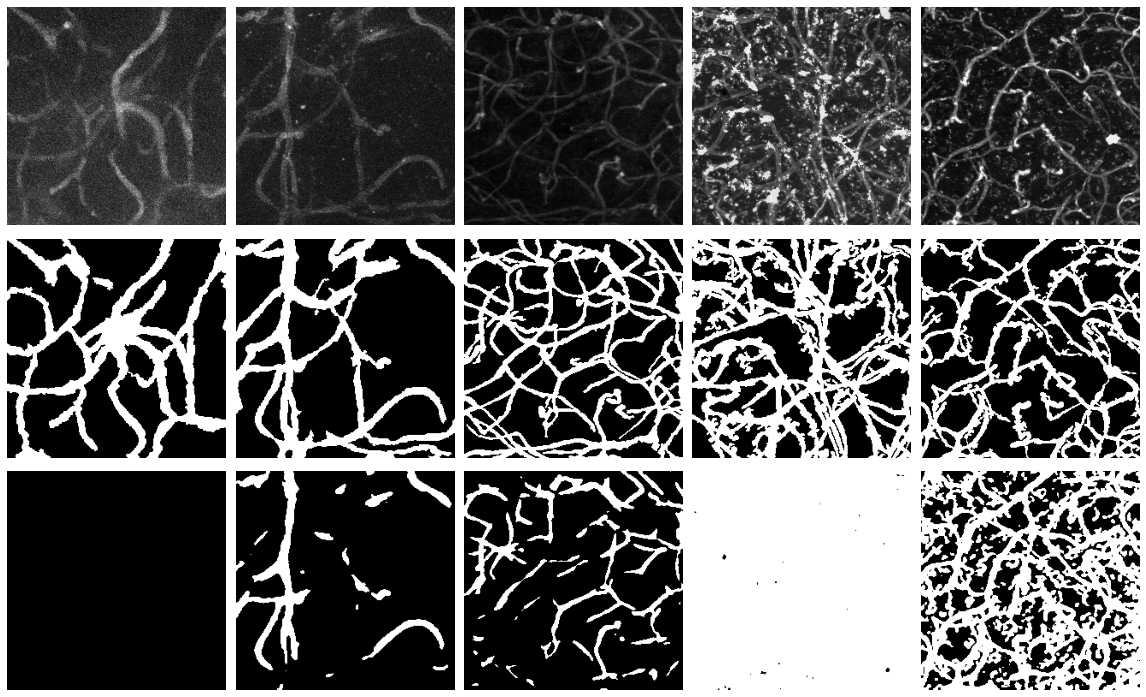

In [8]:
#plot das piores imagens
fig, axs = plt.subplots(3, 5, figsize=(16,22))

for idx, i in zip(range(len(lowest_iou)), lowest_iou):
    img, target = ds_valid[i]
    with torch.no_grad():
        scores = model(img.unsqueeze(0))#['out']
    pred = torch.argmax(scores, dim=1)[0]
    axs[0,idx].imshow(img[0], 'gray')
    axs[0,idx].axis('off')
    axs[1,idx].imshow(target, 'gray')
    axs[1,idx].axis('off')
    axs[2,idx].imshow(pred, 'gray')
    axs[2,idx].axis('off')

plt.tight_layout(pad=1.0)
plt.subplots_adjust(top=0.95, bottom=0.45)
plt.savefig(f'../plots/piores_casos_{model_name}.pdf', bbox_inches='tight')
plt.show()

## Melhores Situações

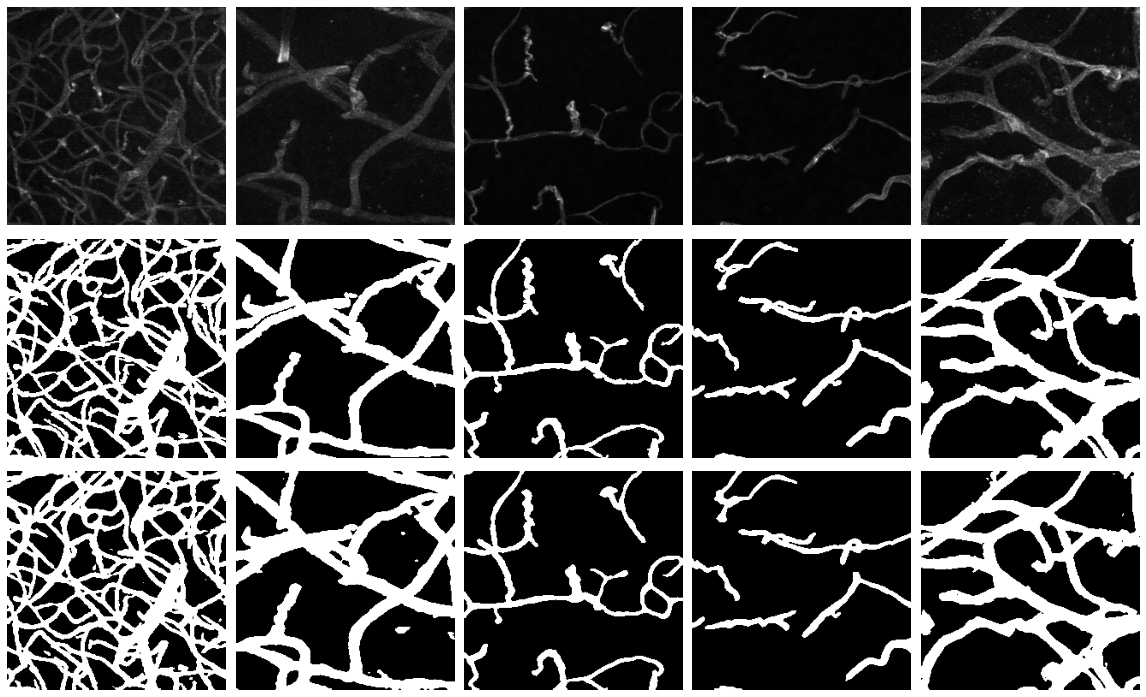

In [9]:
#plot das melhores imagens
fig, axs = plt.subplots(3, 5, figsize=(16,22))

for idx, i in zip(range(len(highest_iou)), highest_iou):
    img, target = ds_valid[i]
    with torch.no_grad():
        scores = model(img.unsqueeze(0))#['out']
    pred = torch.argmax(scores, dim=1)[0]
    axs[0,idx].imshow(img[0], 'gray')
    axs[0,idx].axis('off')
    axs[1,idx].imshow(target, 'gray')
    axs[1,idx].axis('off')
    axs[2,idx].imshow(pred, 'gray')
    axs[2,idx].axis('off')

plt.tight_layout(pad=1.0)
plt.subplots_adjust(top=0.95, bottom=0.45)
plt.savefig(f'../plots/melhores_casos_{model_name}.pdf', bbox_inches='tight')
plt.show()